# Segmentation & Labeling for Multi-track Piano-rolls

This file contains preliminary results of segmentation and labeling for multi-track piano-rolls.

In [3]:
%matplotlib inline
import os
import json
import errno
import random
import warnings
import joblib
import numpy as np
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics.pairwise import pairwise_distances
import pretty_midi
from pypianoroll import Multitrack, Track

## Utility Functions

In [4]:
def make_sure_path_exists(path):
    """Create intermidate directories if the path does not exist."""
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

def moving_average(data, window, mode='valid'):
    """Return the moving averages of the data."""
    weights = np.repeat(1.0, window) / window
    return np.convolve(data, weights, mode)

def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def get_npz_path(msd_id):
    """Given an MSD ID, return the path to the corresponding npz file."""
    return os.path.join(config['lpd_root'], msd_id_to_dirs(msd_id),
                        id_md5[msd_id] + '.npz')

def get_multitrack(msd_id):
    """Given an MSD ID, return the loaded multi-track piano-roll."""
    return Multitrack(get_npz_path(msd_id))

## Configurations

In [5]:
# Matplotlib
matplotlib.rcParams['font.family'] = 'serif' # 'roman'
matplotlib.rcParams['font.size'] = 6.0
matplotlib.rcParams['axes.titleweight'] = 'bold'
matplotlib.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['savefig.dpi'] = 300
# Uncomment the following two lines to deal with the bold roman font bug
#     when using roman font Deal with the bold roman font bug.
#     (See https://github.com/matplotlib/matplotlib/issues/5574)
# del matplotlib.font_manager.weight_dict['roman']
# matplotlib.font_manager._rebuild()

In [6]:
config = {}

# Paths
config['lpd_root'] = "/home/salu133445/NAS/salu133445/lpd/lpd/lpd_cleansed/"
config['id_path'] = "/home/salu133445/NAS/salu133445/lpd/cleansed_ids.txt"
config['id_lists_root'] = ("/home/salu133445/NAS/salu133445/git/musegan/"
                           "preprocessing/id_lists")
config['result_dir'] = "./segmentation/"

# File format
config['extension'] = 'png' # 'pdf', 'ps', 'eps', 'svg'

In [7]:
# Make sure the result directory exists
make_sure_path_exists(config['result_dir'])

# Load the id_md5 dictionary
with open(config['id_path']) as f:
    id_md5 = {line.split()[1]: line.split()[0] for line in f}

## Visualizations of Multi-track Piano-rolls in the Dataset

In [120]:
def visualization(fn):
    """Decorator for visualization functions."""
    def decorated(*args, **kwargs):
        returns = fn(*args, **kwargs)
        if 'size' not in kwargs:
            kwargs['size'] = (10, 3)
        returns[0].set_size_inches(kwargs['size'][0], kwargs['size'][1])
        if 'filename' in kwargs:
            if 'dpi' not in kwargs:
                kwargs['dpi'] = 1200
            if '.' in kwargs['filename']:
                filepath = os.path.join(config['result_dir'],
                                        "{}.{}".format(kwargs['filename'],
                                                       config['extension']))
            else:
                filepath = os.path.join(config['result_dir'],
                                        kwargs['filename'])
            plt.savefig(filepath, dpi=kwargs['dpi'], bbox_inches='tight')
        return returns
    return decorated

def visualize_multitrack(m):
    """Visualize a multi-track piano-roll."""
    bar_resolution = 4 * m.beat_resolution
    fig, axs = m.plot(preset='frame', grid='x')
    plt.minorticks_off()
    num_bar = m.tracks[0].pianoroll.shape[0] // bar_resolution
    xticks_major = bar_resolution * np.arange(0, num_bar)
    for ax in axs:
        ax.set_xticks(xticks_major)
    return fig, axs

@visualization
def visualize(m, **kwargs):
    """Visualize a multi-track piano-roll. See `visualize_multitrack()` for the
    documentation."""
    return visualize_multitrack(m, **kwargs)

def get_activation_boundaries(m, resolution=96, tolerance=0):
    """Returm a list of activation boundaries of the tracks in a multi-track
    piano-roll."""
    num_unit = m.tracks[0].pianoroll.shape[0] // resolution
    activation_boundaries = []
    for idx, track in enumerate(m.tracks):
        activation = np.any(track.pianoroll.reshape(num_unit, -1), axis=1)
        padded = np.pad(activation, (1, 1), 'constant')
        diff = np.diff(padded.astype(int))
        starts = (diff == 1).nonzero()[0] * resolution
        ends = (diff == -1).nonzero()[0] * resolution
        
        to_joins = []
        for i, (start, end) in enumerate(zip(starts, ends)):
            if (end - start) // resolution < 4:
                if i:
                    if (start - ends[i - 1]) // resolution < 3:
                        if (i - 1) not in to_joins:
                            to_joins.append(i - 1)
                if i < len(starts) - 1:
                    if (starts[i + 1] - end) // resolution < 3:
                        if i not in to_joins:
                            to_joins.append(i)

        starts = starts.tolist()
        ends = ends.tolist()
        to_joins.sort(reverse=True)
        for to_join in to_joins:
            del starts[to_join + 1]
            del ends[to_join]
        
        if tolerance:
            boundaries = []
            for start, end in zip(starts, ends):
                to_check = resolution - tolerance
                if not np.any(track.pianoroll[start:(start + to_check)]):
                    start = start + resolution
                if not np.any(track.pianoroll[(end - to_check):end]):
                    end = end - resolution
                if end <= start:
                    continue
                boundaries.append((start, end))            
            activation_boundaries.append(np.array(boundaries))
        else:
            stacked = np.stack((starts, ends), -1)
            activation_boundaries.append(stacked)
    return activation_boundaries

@visualization
def visualize_with_activation_boundaries(m, resolution=96, tolerance=0,
                                         return_boundaries=False, **kwargs):
    """Visualize a multi-track piano-roll with activation boundaries."""
    m.pad_to_multiple(resolution)
    fig, axs = visualize_multitrack(m)
    activation_boundaries = get_activation_boundaries(m, resolution=resolution,
                                                      tolerance=tolerance)
    for idx, track_activation_boundaries in enumerate(activation_boundaries):
        for boundary_pair in track_activation_boundaries:
            position = boundary_pair[0]
            width = (boundary_pair[1] - boundary_pair[0])
            axs[idx].add_patch(
                matplotlib.patches.Rectangle(
                    (position, 0), width, 128, facecolor='k', alpha=0.05
                ))
            axs[idx].add_patch(
                matplotlib.patches.Rectangle(
                    (position, 0), width, 128, facecolor='none', edgecolor='r',
                    linestyle='-', linewidth=1                   
                ))
    if return_boundaries:
        return fig, axs, activation_boundaries
    else:
        return fig, axs

@visualization
def visualize_with_activation_boundaries_common(m, resolution=96, tolerance=0,
                                                segment_resolution=384,
                                                **kwargs):
    fig, axs, activation_boundaries = visualize_with_activation_boundaries(
        m, resolution=96, tolerance=0, return_boundaries=True)
    # mark common boundaries
    uniques, counts = np.unique(np.concatenate(activation_boundaries, axis=0),
                                return_counts=True)
    collected = [unique for idx, unique in enumerate(uniques)
                 if counts[idx] >= (len(m.tracks) // 3)]
    if collected:
        for ax in axs:
            for x in collected:
                ax.axvline(x, color='b', linestyle='-', linewidth=2)
        prev = collected[0]
        for now in collected[1:]:
            if (now - prev) % segment_resolution == 0:
                for x in range(prev, now, segment_resolution):
                    for ax in axs:
                        ax.axvline(x, color='g', linestyle='-', linewidth=1)
        prev = now
    return fig, axs

@visualization
def visualize_with_activation_boundaries_v4(m, **kwargs):
    bar_resolution = 4 * m.beat_resolution
    m.pad_to_multiple(bar_resolution)
    fig, axs = visualize_multitrack(m, size=size)
    num_bar = m.tracks[0].pianoroll.shape[0] // bar_resolution
    boundaries = []
    for idx, track in enumerate(m.tracks):
        activations = track.pianoroll.reshape(num_bar, -1).any(axis=1)
        padded = np.pad(activations, (1, 1), 'constant')
        diff = np.diff(padded.astype(int))
        starts = (diff == 1).nonzero()[0]
        ends = (diff == -1).nonzero()[0]

        to_join = []
        for i, (start, end) in enumerate(zip(starts, ends)):
            if (end - start) < 4:
                if i:
                    if start - ends[i - 1] < 3:
                        to_join.append(i - 1)
                if i < len(starts) - 1:
                    if starts[i + 1] - end < 3:
                        to_join.append(i)
        
        starts = starts.tolist()
        ends = ends.tolist()
        to_join =list(set(to_join))
        to_join.sort()
        while to_join:
            to_del = to_join.pop()
            del starts[to_del + 1]
            del ends[to_del]
        
        for start, end in zip(starts, ends):
            if not track.pianoroll[(start * bar_resolution):(start * bar_resolution + 2 * m.beat_resolution)].any():
                start = start + 1
            if not track.pianoroll[(end * bar_resolution - 2 * m.beat_resolution):(end * bar_resolution)].any():
                end = end - 1
            if (end - start) < 2:
                x = start * bar_resolution
                w = (end - start) * bar_resolution
                axs[idx].add_patch(
                matplotlib.patches.Rectangle(
                    (x, 0), w, 128, facecolor='none', edgecolor='xkcd:orange',
                    linestyle='-', linewidth=1                    
                ))
                continue
            boundaries.append(start)
            boundaries.append(end)
            x = start * bar_resolution
            w = (end - start) * bar_resolution
            axs[idx].add_patch(
                matplotlib.patches.Rectangle(
                    (x, 0), w, 128, facecolor='k', alpha=0.05
                ))
            axs[idx].add_patch(
                matplotlib.patches.Rectangle(
                    (x, 0), w, 128, facecolor='none', edgecolor='r',
                    linestyle='-', linewidth=1                    
                ))

    mod = np.mod(boundaries, 4)
    offset = np.bincount(mod).argmax()
    
    for x in range(offset, num_bar, 4):
        for ax in axs:
            ax.axvline(x * bar_resolution, color='g', linestyle='-',
                       linewidth=.5)
    return fig, axs

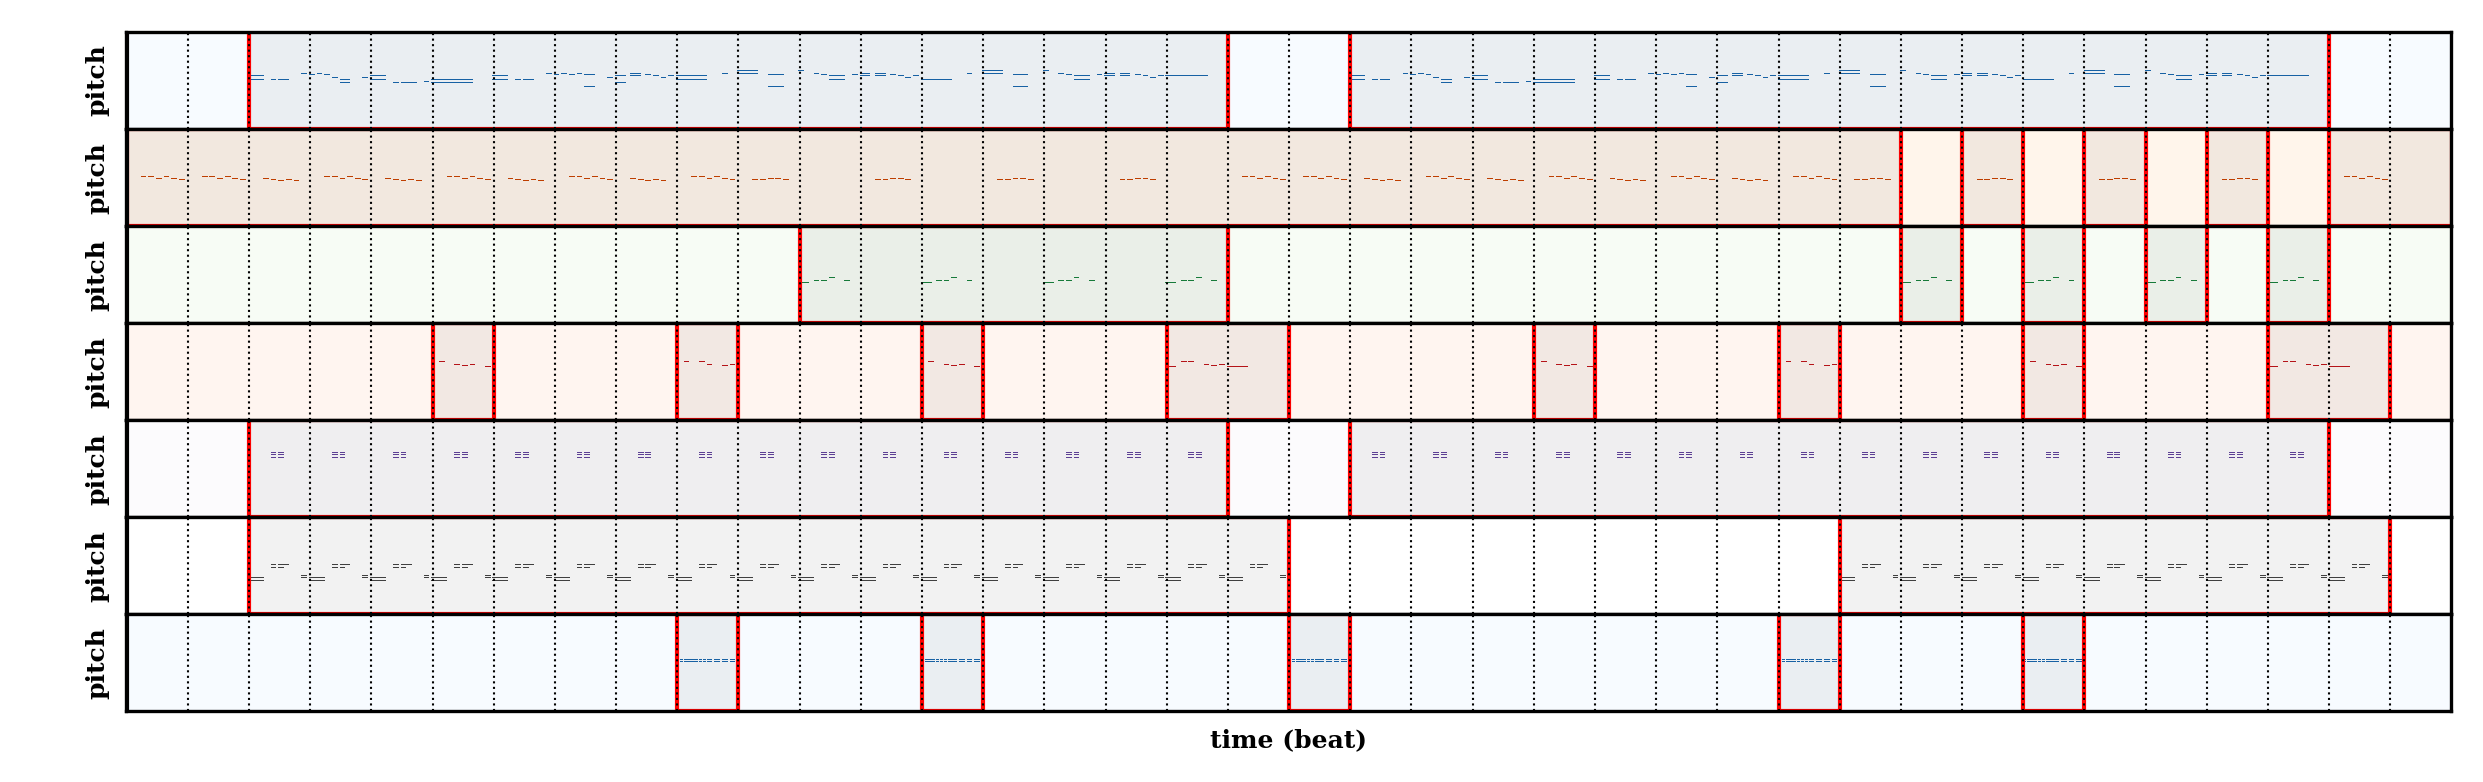

In [56]:
m = get_multitrack(random.choice(list(id_md5.keys())))
_ = visualize_with_activation_boundaries(m, tolerance=24)

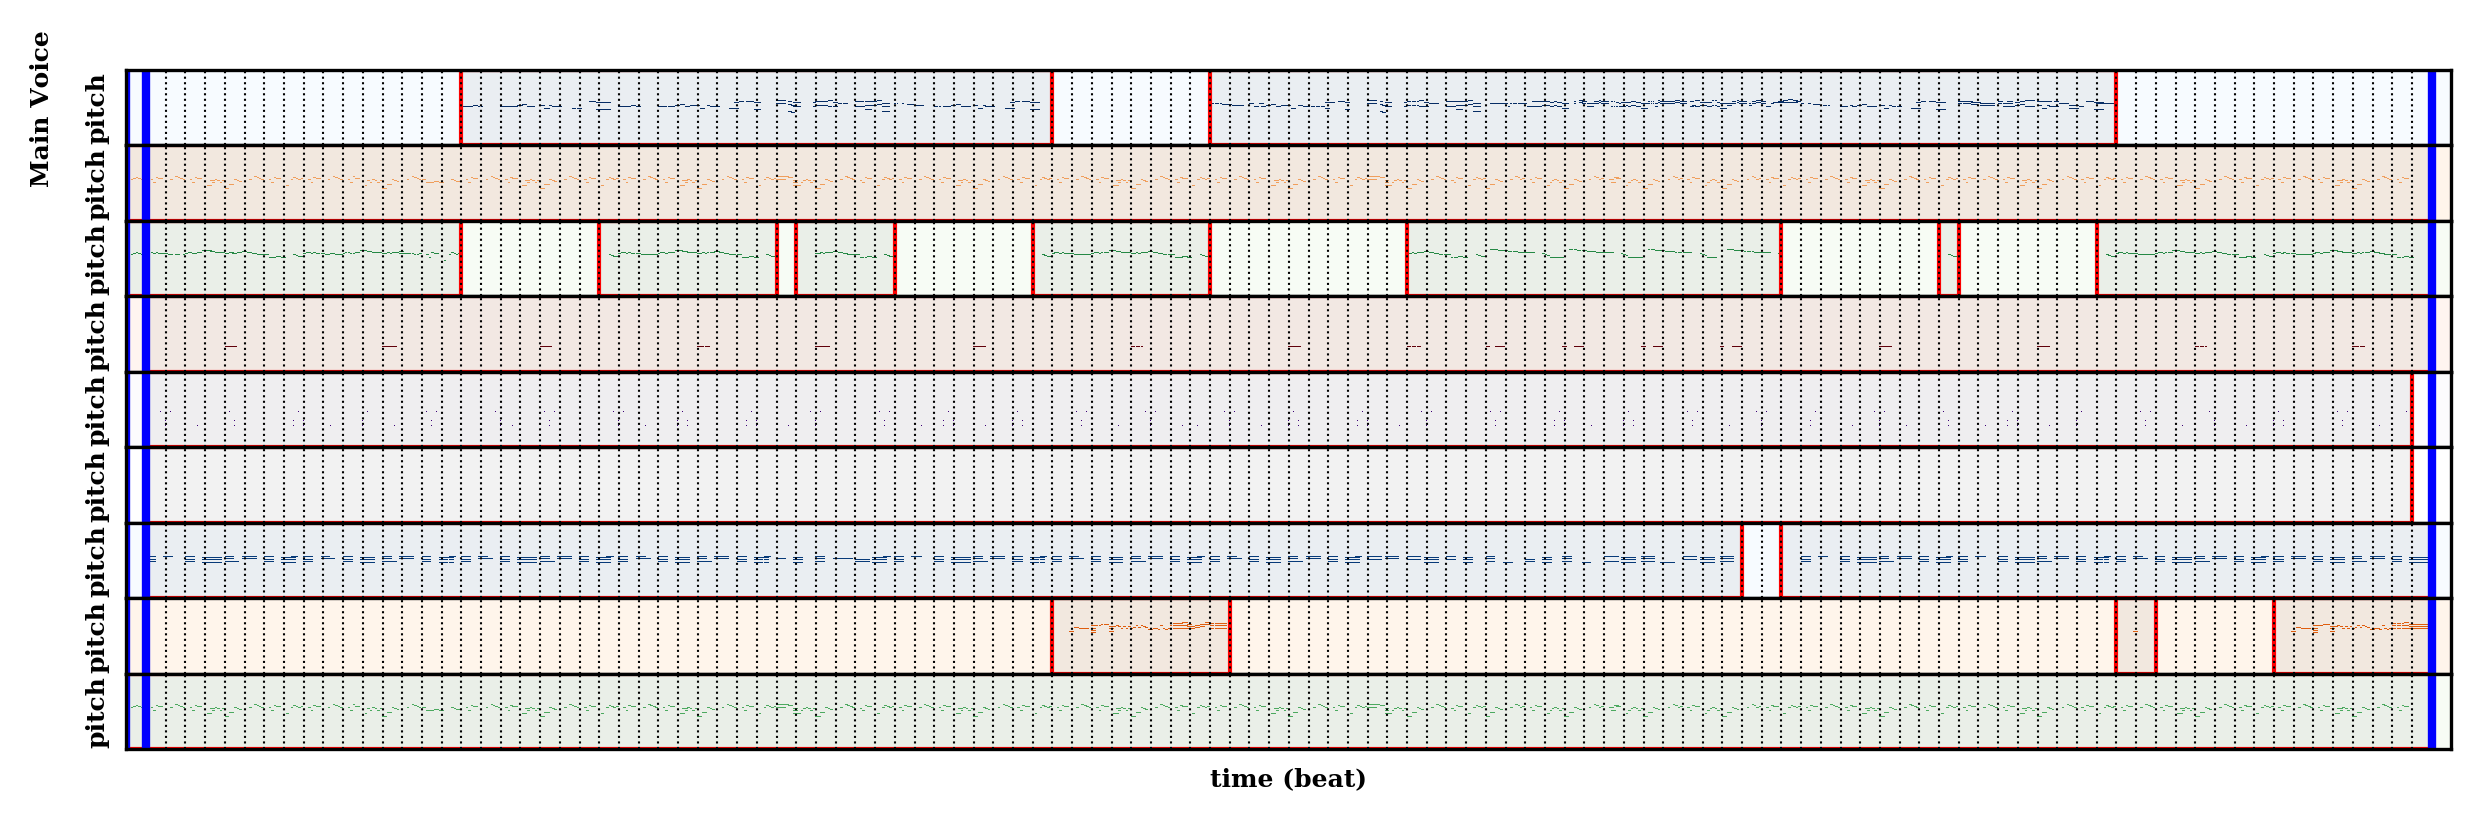

In [129]:
m = get_multitrack(random.choice(list(id_md5.keys())))
_ = visualize_with_activation_boundaries_common(m, tolerance=48, dpi=2000)

KeyboardInterrupt: 

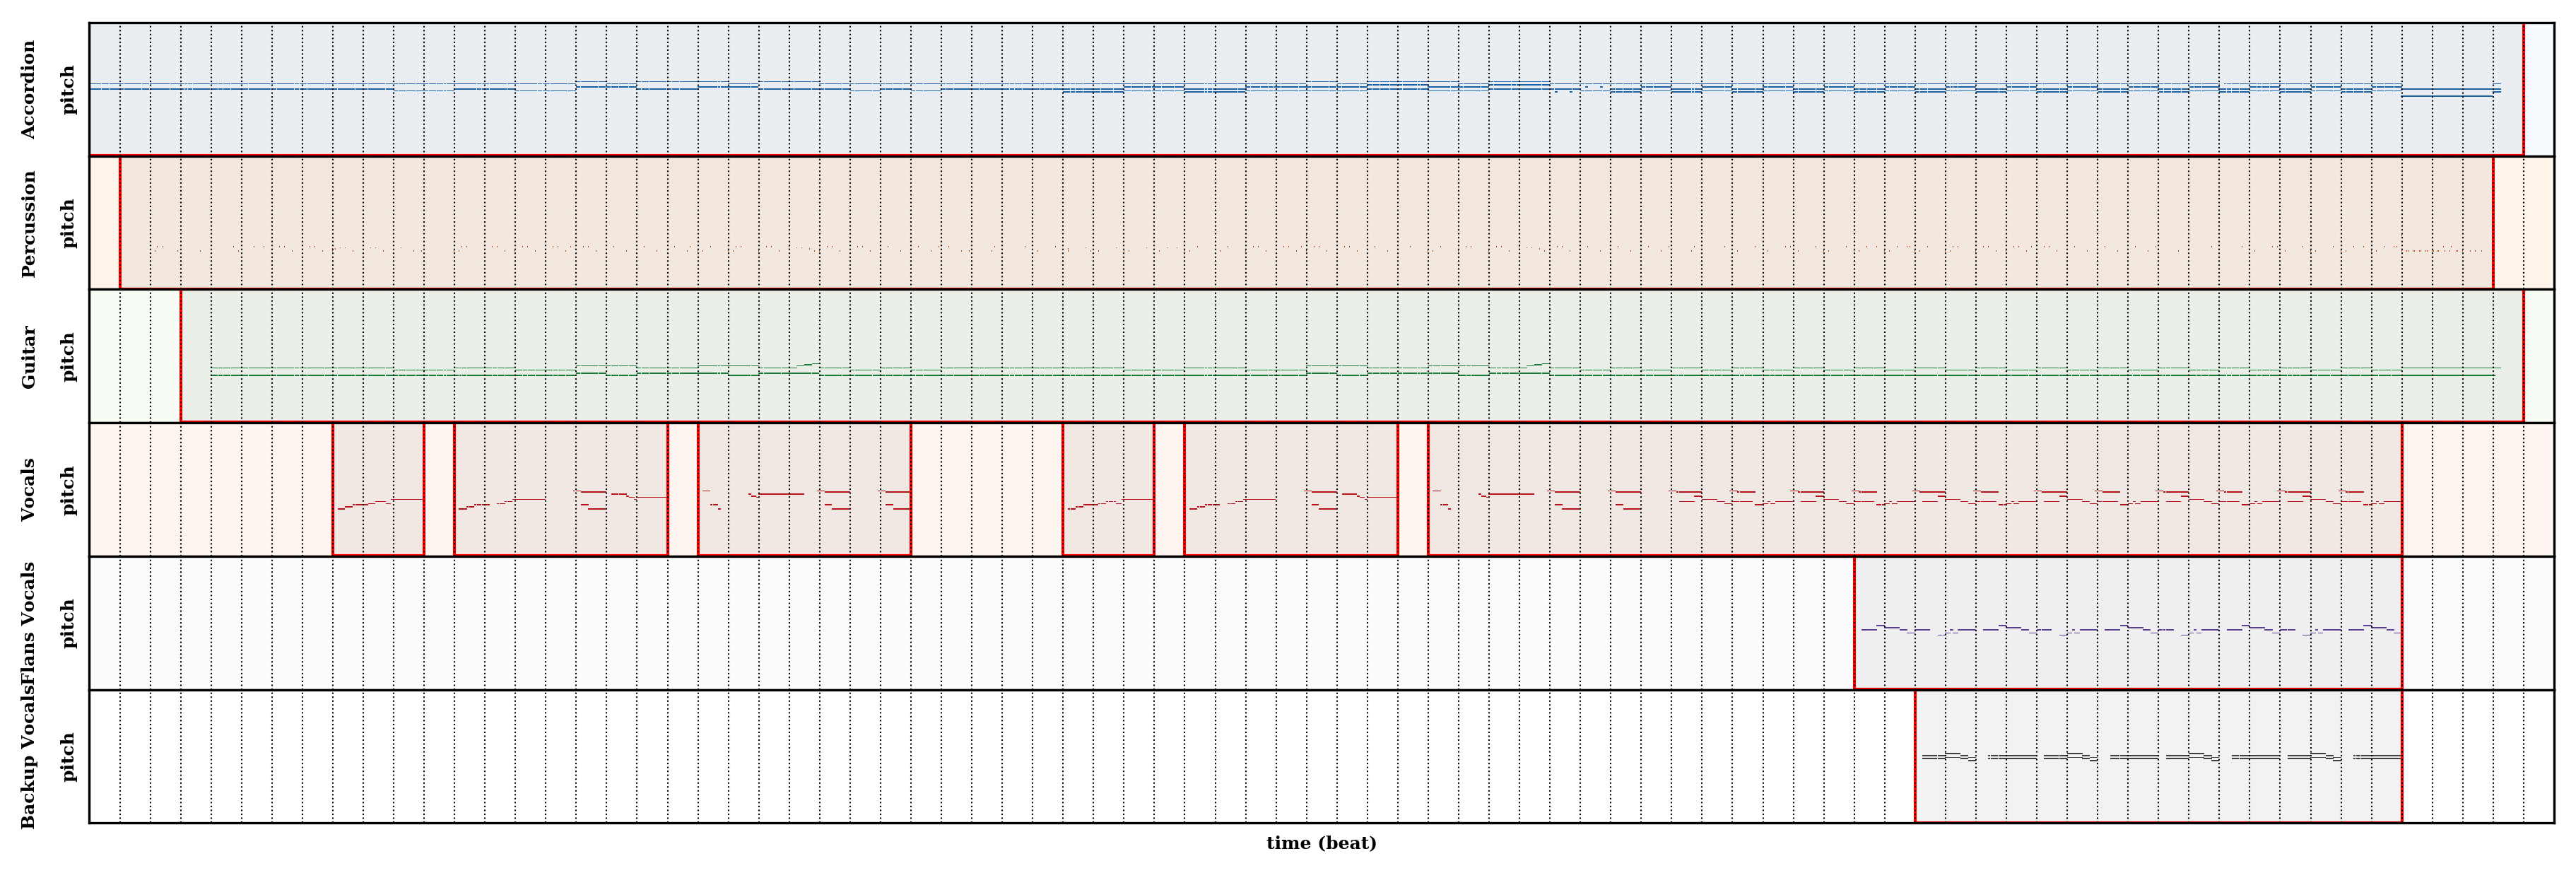

In [49]:
folder_name = 'activation_boundaries'
make_sure_path_exists(os.path.join(result_dir, folder_name))

for n in range(10):
    m = get_multitrack(random.choice(list(id_md5.keys())))
    while len(m.tracks) > 20:
        m = get_multitrack(random.choice(list(id_md5.keys())))
    visualize_with_activation_boundaries(m, show=False)
#     plt.savefig(os.path.join(result_dir, folder_name,
#                              "{}_LQ.{}".format(n, extension)),
#                 dpi=300, bbox_inches='tight')
#     plt.savefig(os.path.join(result_dir, folder_name,
#                              "{}_HQ.{}".format(n, extension)),
#                 dpi=600, bbox_inches='tight')
    plt.close()

## Self-similarity Matrices

In [27]:
def compute_ssm_track(pianoroll, resolution, bar_resolution, metric):
    flatten = pianoroll.reshape(-1, bar_resolution * 128 * resolution)
    distances = pairwise_distances(flatten.astype(float), metric=metric, n_jobs=30)
    return distances
    
def compute_ssm(m, resolution=1, offset=0, metric='euclidean', normalized=True, ignore_empty_bars=True):
    m.binarize()
    bar_resolution = 4 * m.beat_resolution
    num_bar = m.tracks[0].pianoroll.shape[0] // bar_resolution
    if resolution == 1:
        features = np.zeros((num_bar, num_bar))
        for track in m.tracks:
            features += compute_ssm_track(track.pianoroll, resolution,
                                          bar_resolution, metric)
    elif resolution > 1:
        num_selected_bar = (num_bar - offset - 1) - (num_bar - offset - 1) % 4
        start = offset * m.beat_resolution * 4
        end = (offset + num_selected_bar) * m.beat_resolution * 4
        features = np.zeros((num_selected_bar // 4, num_selected_bar // 4))
        for track in m.tracks:
            features += compute_ssm_track(track.pianoroll[start:end], resolution,
                                          bar_resolution, metric)
    if normalized:
        features = features / np.max(features)
    if ignore_empty_bars:
        bar_resolution = 4 * m.beat_resolution
        num_bar = m.tracks[0].pianoroll.shape[0] // bar_resolution
        activations = m.tracks[0].pianoroll.reshape(num_bar, -1).any(axis=1)
        for track in m.tracks[1:]:
            activations = np.logical_or(activations,
                                        np.any(track.pianoroll.reshape(num_bar, -1),
                                               axis=1))
        features[~activations] = np.max(features)
        features[:, ~activations] = np.max(features)
    return features

def plot_ssm(features, threshold=None, cmap='inferno', colorbar=True,
             filename=None, size=(3, 3), dpi=None, **kwargs):
    plt.imshow(features, cmap=cmap, **kwargs)
    plt.gcf().set_size_inches(size[0], size[1])
    plt.title("Self-similarity matrix")
    if colorbar:
        plt.colorbar()
    if filename is not None:
        plt.savefig(process_filename(filename), dpi=dpi, bbox_inches='tight')

def smart_histogram(data, bins=100, filename=None, size=(3, 2), dpi=None,
                    **kwargs):
    plt.hist(data.reshape(-1), bins=bins, **kwargs)
    plt.gcf().set_size_inches(size[0], size[1])
    order = 10 ** (np.ceil(np.log10(data.max())) - 1)
    plt.xlim(0, (data.max() // order + 1) * order)
    if filename is not None:
        plt.savefig(process_filename(filename), dpi=dpi, bbox_inches='tight')

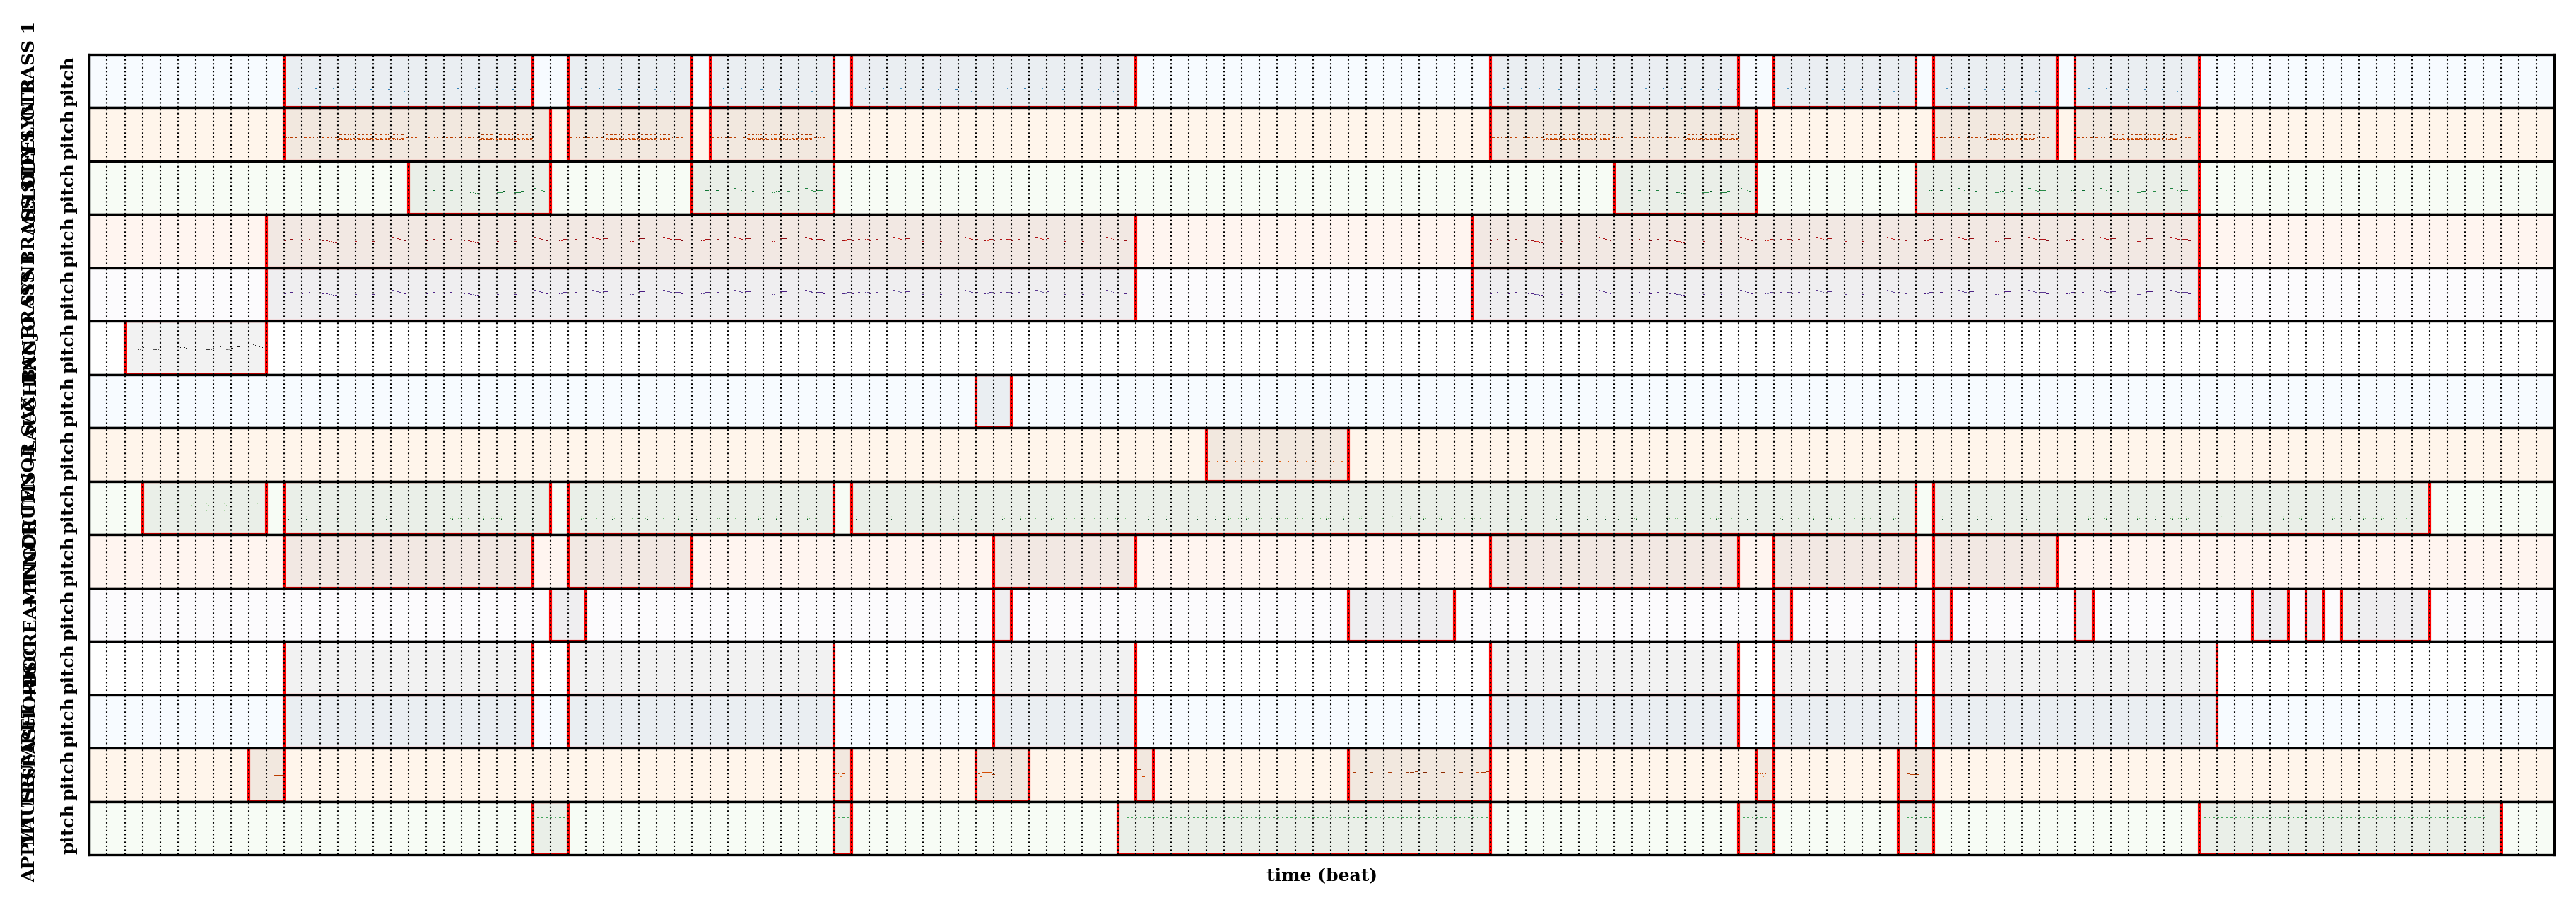

In [14]:
m = get_multitrack(random.choice(list(id_md5.keys())))
m.pad_to_multiple(96)
_ = visualize_with_activation_boundaries(m)

In [15]:
features_l1 = compute_ssm(m, resolution=1, offset=0, metric='l1')
# plot_ssm(features_l1)

In [16]:
features_l2 = compute_ssm(m, resolution=1, offset=0, metric='l2')
# plot_ssm(features_l2)

In [17]:
# smart_histogram(features_l1, histtype='step', linewidth=.5, label='l1_distance')
# smart_histogram(features_l2, histtype='step', linewidth=.5, label='l2_distance')
# plt.legend(loc=2)
# plt.show()

In [31]:
convolved_l1 = scipy.signal.convolve2d(features_l1, np.identity(4), mode='valid')
convolved_l1 = convolved_l1 / np.max(convolved_l1)
# plot_ssm((convolved_l1 < 0.1).astype(float))

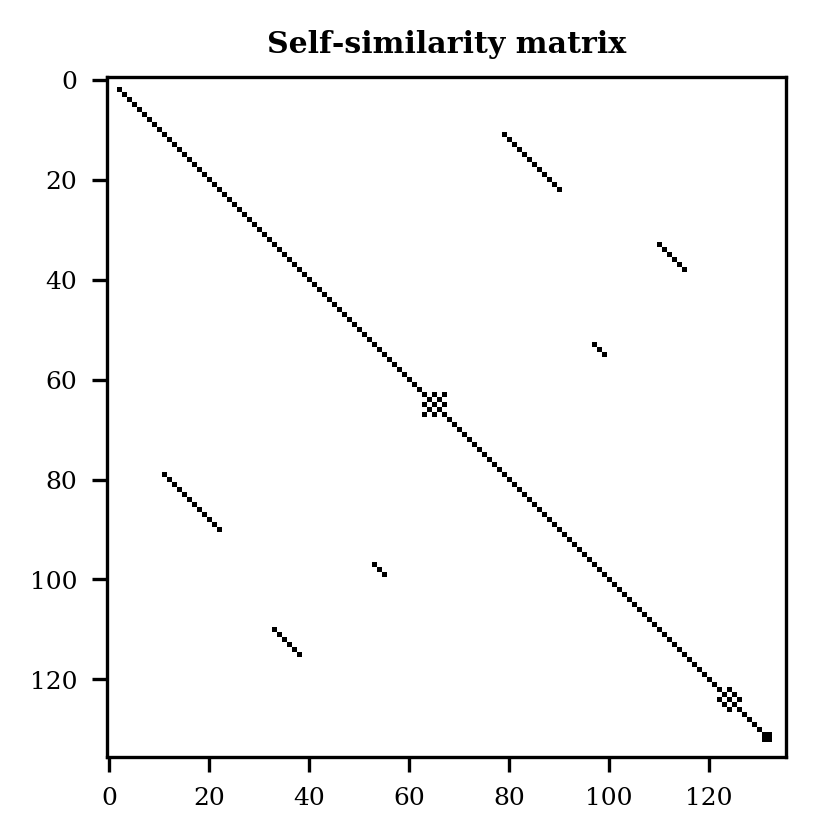

In [32]:
convolved_l2 = scipy.signal.convolve2d(features_l2, np.identity(4), mode='valid')
convolved_l2 = convolved_l2 / np.max(convolved_l2)
plot_ssm((convolved_l2 < 0.05).astype(float), cmap='binary', colorbar=False)

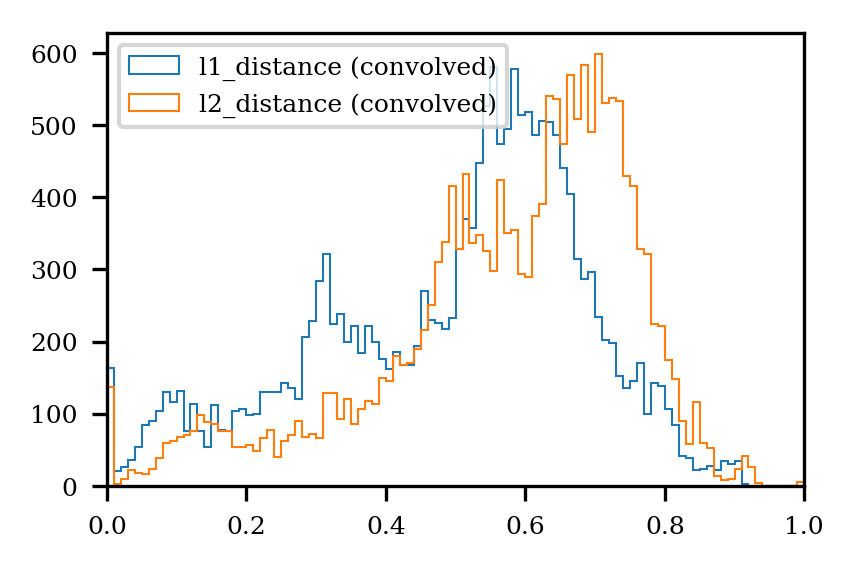

In [22]:
smart_histogram(convolved_l1, histtype='step', linewidth=.5, label='l1_distance (convolved)')
smart_histogram(convolved_l2, histtype='step', linewidth=.5, label='l2_distance (convolved)')
plt.legend(loc=2)
plt.show()

## Detecting Repeating Segments

In [95]:
def visualize(m, filename=None, size=(15, 5), dpi=None):
    bar_resolution = 4 * m.beat_resolution
    m.pad_to_multiple(bar_resolution)
    fig, axs = visualize_multitrack(m, size=size)
    
    for idx, track in enumerate(m.tracks):
        boundaries = get_boundaries(track.pianoroll)
        for (start, end) in boundaries:
            x = start * bar_resolution
            w = (end - start) * bar_resolution
            axs[idx].add_patch(
                matplotlib.patches.Rectangle(
                    (x, 0), w, 128, facecolor='k', alpha=0.05
                ))
            axs[idx].add_patch(
                matplotlib.patches.Rectangle(
                    (x, 0), w, 128, facecolor='none', edgecolor='r',
                    linestyle='-', linewidth=1                    
                ))

    if filename is not None:
        plt.savefig(process_filename(filename), dpi=dpi, bbox_inches='tight')

    return fig, axs
    
def get_boundaries(pianoroll, algorithm=None):
    bar_resolution = 4 * m.beat_resolution
    num_bar = m.tracks[0].pianoroll.shape[0] // bar_resolution

    activations = pianoroll.reshape(num_bar, -1).any(axis=1)
    padded = np.pad(activations, (1, 1), 'constant')
    diff = np.diff(padded.astype(int))
    starts = (diff == 1).nonzero()[0]
    ends = (diff == -1).nonzero()[0]

    to_join = []
    for i, (start, end) in enumerate(zip(starts, ends)):
        if (end - start) < 4:
            if i:
                if start - ends[i - 1] < 3:
                    to_join.append(i - 1)
            if i < len(starts) - 1:
                if starts[i + 1] - end < 3:
                    to_join.append(i)

    starts = starts.tolist()
    ends = ends.tolist()
    to_join =list(set(to_join))
    to_join.sort()
    while to_join:
        to_del = to_join.pop()
        del starts[to_del + 1]
        del ends[to_del]

    boundaries = []
    for start, end in zip(starts, ends):
        if not pianoroll[(start * bar_resolution):(start * bar_resolution + 2 * m.beat_resolution)].any():
            start = start + 1
        if not pianoroll[(end * bar_resolution - 2 * m.beat_resolution):(end * bar_resolution)].any():
            end = end - 1
        if (end - start) < 2:
            continue
        boundaries.append((start, end))
        
    return boundaries

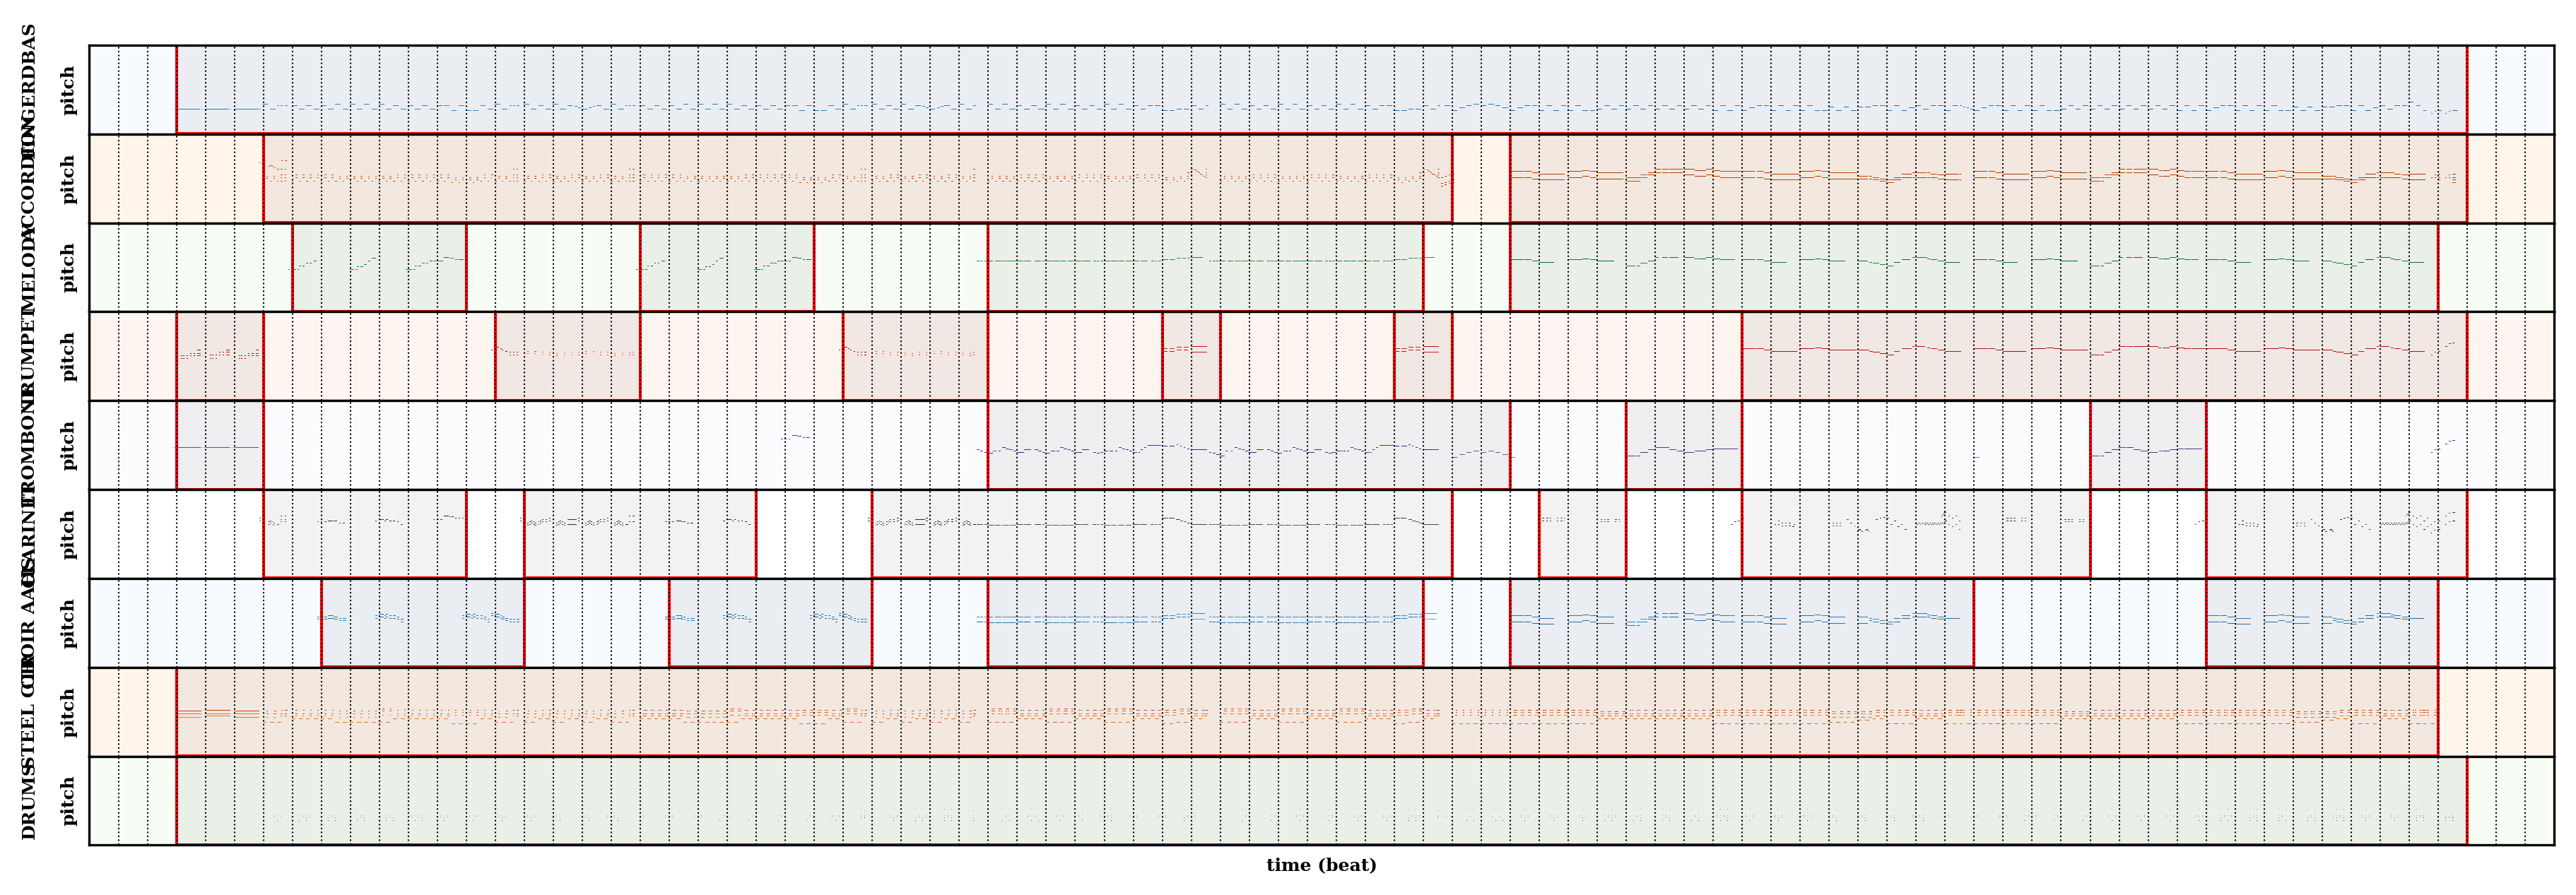

In [97]:
m = get_multitrack(random.choice(list(id_md5.keys())))
_ = visualize(m)

In [ ]:
def naive_repeat_detection(m):
    for idx, track in enumerate(m.tracks):
        reshaped = track.pianoroll.reshape(num_bar, -1)
        activations = reshaped.any(axis=1)
        padded = np.pad(activations, (1, 1), 'constant')
        diff = np.diff(padded.astype(int))
        starts = (diff == 1).nonzero()[0]
        ends = (diff == -1).nonzero()[0]
        for start, end in zip(starts, ends):
            reshaped[start:end]
        
        
        
        
        marked = np.copy(activations)
        collected = []
        while np.sum(marked) > 0:
            first = np.argmax(marked)
            last = first + 1
            candidates = ((reshaped - reshaped[first]) ** 2 < 10).nonzeros()
            for candicates:
                reshaped[first:last]
                last += 1
            